# Feature selection

The purpose of this post is to explore feature selection techniques, namely:
    * Correlation based
    * K-best
    * In-built features importance of Random Forest
    * Permutation importances

# Data exploration
The dataset is taken from Kaggle: https://www.kaggle.com/c/santander-customer-transaction-prediction

Load and inspect data,  check dimensions, data types, missing values, target variable

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_train = pd.read_csv('../input/train.csv')
print(df_train.shape)
df_train.head()

(200000, 202)


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [3]:
def check_missing(df):
    return df.isnull().sum().sum()
print(f'Missing values {check_missing(df_train)}')

Missing values 0


In [4]:
df_train.dtypes.value_counts()

float64    200
object       1
int64        1
dtype: int64

In [5]:
df_train.target.sum() / df_train.shape[0]

0.10049

Quite large dataset with 200 numerical features, no missing values and all variable names anonymyzed, target class is inbalanced.

# Sampling

In real life scenarios we would want to keep as much information as possible, given resource constraints and probably use model weights instead of downsampling. However, for the purpose of this post, let's downsample majority class to achieve 1:1 ratio, which will both speed up exploration and simplify accuracy measurement.

In [6]:
# Drop ID column as it doesn't contain information
df_train.drop('ID_code', axis=1, inplace=True)

In [7]:
df_positive_class = df_train[df_train.target == 1]
df_negative_class = df_train[df_train.target == 0].sample(df_positive_class.shape[0], replace=False, random_state=42)
sample_df = pd.concat([df_positive_class, df_negative_class], axis=0)
sample_df.target.value_counts()

1    20098
0    20098
Name: target, dtype: int64

Separate X and y, add random feature for importance reference, change dtypes to float32 to speedup processing

In [8]:
np.random.seed(42)
X = (sample_df.drop('target', axis=1)
     .apply(lambda x: x.astype('float32'))
     .assign(rand=lambda x: np.random.rand(x.shape[0])))
y = sample_df.target

Create train test splits

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

# The benchmark

Typical framework for such experiments is building the simplest solution first and then trying different techniques to improve it.
Let's use the usual Random Forest classifier, which is the go-to choice for prototyping, idea testing and experimentation.
We'll fit it on all features to get the benchmark and then try to reduce the number of features while maintaining as high accuracy as possible.
Besides accuracy score, let's keep track of prediction time - a pretend scenario for when real time speed is important, this will add more motivation for dimensionality reduction.
Remember, simple = good :)

In [10]:
import time
def score_and_time(model, X):
    ts = time.time()
    preds = model.predict(X)
    elapsed = int((time.time() - ts) * 1000)
    print(f'Score {model.oob_score_}, predicted in {elapsed}')

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

baseline = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1, random_state=42)
baseline.fit(X_train, y_train)
score_and_time(baseline, X_test)

Score 0.7065244433387238, predicted in 209


# In-built feature importance

Random Forest was chosen for another nice property - it has in-built feature importance feature after fitting it, which saves considerable amount of coding.
Let's use already fitted benchmark to get the important features.

Number of features with greater than random column importance 178


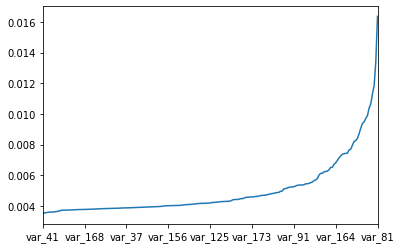

In [12]:
importances = pd.Series(baseline.feature_importances_, index=X_train.columns)
important_cols = importances[importances > importances['rand']].index.tolist()
print(f'Number of features with greater than random column importance {len(important_cols)}')
importances.sort_values().plot()

In [13]:
reduced_rf = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1, random_state=42)
reduced_rf.fit(X_train[important_cols], y_train)
score_and_time(reduced_rf, X_test[important_cols])

Score 0.7095720860803583, predicted in 205


Ok, so we improved the score somewhat, prediction time is similar, dimensionality is still quite high, around 2/3 of the original input.
Of course, if this was the issue, we could try sacrificing some of the accuracy and choosing less top features, instead of taking all non-random.
Also, importance plot shows exponential decay, so 20/80 principle is applicable here and shouldn't hurt accuracy too much.

# Importance based on correlation to target

Another way to perform variable selection that is more traditional and related to linear models is by picking features that are most correlated to target variable.
Since most of the relationships in real world are not linear, we'll use Spearman's rank correlation instead of Pearson's correlation, because it's more robust and better captures non-linearities.
Also, even though pandas has in-built correlation method, let's use scipy's implementation, since it's more efficient.

Some practitioners suggest investigating relationships between features first, because multicollinearity has an effect on importances, i.e. correlated variables will both seem important but contain nearly identical information. But let's leave it for now, because it would unnecessarily complicate implementation if we wanted to automate this process.

Number of variables with correlation to target higher than random 199


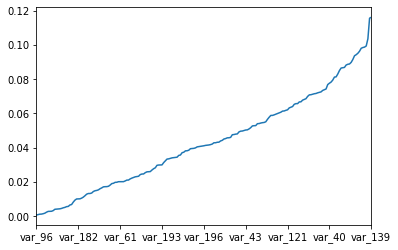

In [14]:
import scipy.stats
_ = pd.concat([X_train,y_train], axis=1)
cor = pd.DataFrame(np.abs(scipy.stats.spearmanr(_).correlation),
                   columns=_.columns, index=_.columns)['target']
non_rand_corr = cor[cor > cor['rand']].shape[0]
print(f'Number of variables with correlation to target higher than random {non_rand_corr}')
cor[cor.index != 'target'].sort_values().plot()

Most of the variables have higher absolute correlation to target than random column, so this heuristic doesn't provide a good variable selection strategy.
Also all variables have very low correlations to target, e.g. 10% at most, so it's not evident how many top variables to select or what correlation threshold to set.
Let's try taking top 20% most correlated variables and see how the score changes.

In [15]:
top20_cols = cor[cor.index != 'target'].sort_values()[-int(cor.shape[0] * .2):].index.tolist()
rf_corr = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1, random_state=42)
rf_corr.fit(X_train[top20_cols], y_train)
print(f'Reduced number of columns {len(top20_cols)}')
score_and_time(rf_corr, X_test[top20_cols])

Reduced number of columns 40
Score 0.7037877845503172, predicted in 104


Ok, so the score decreased slightly, but we reduced input dimension by 80% and prediction time twice!
Of course here top 20 was chosen arbitrarily, we could do a GridSearch approach and get multiple scores for different number of top variables and see how does the trade-off landscape between accuracy and complexity looks like.

In general, in-built selection is preferrable, because importances are calculated directly when fitting trees, so it saves computation and additional code lines, but in general it's good to know alternative methods for later use with algorithms that don't have in-built feature importance calculation.

# Permutation importance

The final technique that I'm going to consider in this post is permutation importance, which as argued (https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py) is superior to default impurity based feature importance.

Additionally, I'll wrap feature selection part into Sklearn pipeline, such that it can be integrated into end-to-end solution.

fit base estimator, in next step get fitted estimator and apply feature importances

In [16]:
# scikit-learn==0.22.2 or higher required
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, ClassifierMixin

class FeatureSelector(BaseEstimator, ClassifierMixin):
    
    # This can be tuned to accept kwargs for pi
    def __init__(self, estimator):
        self.estimator = estimator
    
    def fit(self, X, y=None):
        self.estimator.fit(X, y)
        self.important_cols = self._get_important_cols(X, y)
        self.estimator.fit(X[self.important_cols], y)
        return self
        
    def _get_important_cols(self, X, y):
        pi = permutation_importance(self.estimator, X, y, n_repeats=1, n_jobs=-1, random_state=42)
        importances = pd.DataFrame(pi.importances_mean, index=X.columns, columns=['imp'])['imp']
        return importances[importances > importances['rand']].index.tolist()
    
    def predict(self, X):
        return self.estimator.predict(X[self.important_cols])
    
    @property
    def oob_score_(self):
        return self.estimator.oob_score_

In [17]:
from sklearn.pipeline import Pipeline

clf = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1, random_state=42)
fs = FeatureSelector(clf)

In [18]:
fs.fit(X_train, y_train)
print(f'Number of selected features {len(fs.important_cols)}')
score_and_time(fs, X_test)

Number of selected features 21
Score 0.6743065057843015, predicted in 105


# Conclusion

As you can see using permutation importances didn't seem to prove improve accuracy. It reduced the number of columns down to 21, which seems a little low. It could be due to correlated inputs, for more info see here: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py.
Anyway, it was interesting to implement new Scikit Learn methods, although for practicality I would use in-built importances for dimensionality reduction and then use permutation importances or LIME / SHAP for model interpretation. Additionally, it would be worthwile to play around with automated multicollinearity reduction techniques in the future.